In [1]:
def clip(tmp1):
    import subprocess
    import shlex  # 导入 shlex 模块
    # 使用 shlex.quote 来转义 inp 字符串
    tmp2 = str(tmp1)
    safe_str = shlex.quote(tmp2)
    subprocess.run('echo {} | wclip'.format(safe_str), shell=True)  

def cvin(k):
    clip(In[k])
    
import numpy as np
import matplotlib.pyplot as plt

import copy #复制方法
#格式化输出
np.set_printoptions(precision=3, suppress=True, linewidth=100)

这些术语之间的区别主要在于它们表示的是什么以及它们是如何计算的。以下是对这些术语的详细解释：

1. **策略的状态价值函数 $ V^{\pi}(s) $**:
   - 这表示在状态 $ s $ 下，遵循策略 $ \pi $ 时的期望回报。
   - 它给出了从状态 $ s $ 开始并在之后遵循策略 $ \pi $ 时能得到的期望回报。
   - 公式表示为：
     $$ V^{\pi}(s) = \mathbb{E}_{\pi} \left[ \sum_{t=0}^{\infty} \gamma^t r_t | s_0 = s \right] $$
     其中 $ \gamma $ 是折扣因子，$ r_t $ 是在时间 $ t $ 获得的奖励。

2. **状态的价值函数 $ V^*(s) $**:
   - 这表示在状态 $ s $ 下，遵循最优策略时的期望回报。
   - 它是所有策略下状态价值函数的最大值。
   - 公式表示为：
     $$ V^*(s) = \max_{\pi} V^{\pi}(s) $$

3. **状态和动作的价值函数 $ Q^{\pi}(s, a) $** 或 **Q-函数**:
   - 这表示在状态 $ s $ 下采取动作 $ a $ 并之后遵循策略 $ \pi $ 时的期望回报。
   - 它给出了在状态 $ s $ 采取动作 $ a $，然后在之后的时间步中遵循策略 $ \pi $ 时能得到的期望回报。
   - 公式表示为：
     $$ Q^{\pi}(s, a) = \mathbb{E}_{\pi} \left[ \sum_{t=0}^{\infty} \gamma^t r_t | s_0 = s, a_0 = a \right] $$

这三者之间的主要区别是它们的计算对象和参考点。状态价值函数关注的是从某个状态开始并遵循某个策略的期望回报，而Q-函数关注的是在某个状态下采取某个动作并之后遵循某个策略的期望回报。


### 1.定义悬崖漫步环境CliffWalkEnv
转移矩阵，而且是考虑动作a的前提下，在马尔可夫决策中，我们使用的是P状态转移函数。但是在明确的格子问题中，明显使用矩阵优于转移函数：
注意这个矩阵，原本要用三维的形式，而现在采用二维：把所有格子在一维线性排列

|数据结构:
- nrow 行数
- ncol 列数
- r_normal 普通奖励
- r_cliff 悬崖奖励
- A动作-上|下|左|右
   A = [[0, -1], [0, 1], [-1, 0], [1, 0]] ,左上角为原点，行为y，列为x，四种动作
- P 转移矩阵res(元组列表)
   [s][a] 注意：状态(格子)&动作 均是以下标体现的
   - p 即为 $P(s^{\prime} | s,a)$ 
   - next_s 下一个可能的状态
   - reward 该动作的奖励
   - flag 标志是否到达终点/悬崖

|方法：
- iscliff 判断是否是悬崖
- isend 判断是否是终点
- initP 初始化转移矩阵

In [2]:
class CliffWalkEnv:
    def __init__(self,nrow=4,ncol=12,*,r_normal = -1, r_cliff = -100):
        self.nrow = nrow
        self.ncol = ncol
        self.r_normal = r_normal
        self.r_cliff = r_cliff
        self.A = [[0, -1], [0, 1], [-1, 0], [1, 0]] #上|下|左|右
        self.P = self.iniP()
    
    def isend(self,row,col):
        return row == self.nrow-1 and col == self.ncol-1
    
    def iscliff(self,row,col):
        return row == self.nrow-1 and col > 0 and col != self.ncol-1 
    
    def iniP(self):
        P = [[[] for j in range(len(self.A))] for i in range(self.nrow*self.ncol)]
        k = self.ncol
        A = self.A
        for row in range(self.nrow):
            for col in range(self.ncol):
                for a in range(len(self.A)):
                    if self.isend(row,col) or self.iscliff(row,col):
                        P[row*k+col][a]=[(1,row*k+col,0,True)] #分支：关系到是否还能继续行走
                        continue
                    next_x = min(self.ncol-1,max(0,col+A[a][0]))
                    next_y = min(self.nrow-1,max(0,row+A[a][1]))
                    next_s = next_y * k + next_x
                    reward = self.r_normal
                    flag = False
                    #错误：if self.isend(row,col):
                    if self.isend(next_y,next_x):
                        #reward = 0 #分支
                        flag = True
                    #错误：elif self.iscliff(row,col):
                    elif self.iscliff(next_y,next_x):
                        reward = self.r_cliff
                        flag = True
                    P[row*k+col][a]=[(1,next_s,reward,flag)]
        return P
        

$Q^{\pi}(s, \pi^{\prime}(s)) \geq V^{\pi}(s)$
于是在任意状态 $s$ 下，我们有
$V^{\pi^{\prime}}(s) \geq V^{\pi}(s)$
这便是策略提升定理（policy improvement theorem）。于是我们可以直接贪心地在每一个状态选择动作 价值最大的动作，也就是
$\pi^{\prime}(s)=\arg \max _{a} Q^{\pi}(s, a)=\arg \max _{a}\left\{r(s, a)+\gamma \sum_{s^{\prime}} P\left(s^{\prime} \mid s, a\right) V^{\pi}\left(s^{\prime}\right)\right\}$
我们发现构造的贪心策略 $\pi^{\prime}$ 满足策略提升定理的条件，所以策略 $\pi^{\prime}$ 能够比策略 $\pi$ 更好或者至少与其一样 好。这个根据贪心法选取动作从而得到新的策略的过程称为策略提升。当策略提升之后得到的策略 $\pi^{\prime}$ 和 之前的策略 $\pi$ 一样时，说明策略迭代达到了收敛，此时 $\pi$ 和 $\pi^{\prime}$ 就是最优策略。
策略提升定理的证明通过以下推导过程可以证明，使用上述提升公式得到的新策略 $\pi^{\prime}$ 在每个状态的价值 不低于原策略 $\pi$ 在该状态的价值。
$$
\begin{aligned}
V^{\pi}(s) & \leq Q^{\pi}\left(s, \pi^{\prime}(s)\right) \\
& =\mathbb{E}_{\pi^{\prime}}\left[R_{t}+\gamma V^{\pi}\left(S_{t+1}\right) \mid S_{t}=s\right] \\
& \leq \mathbb{E}_{\pi^{\prime}}\left[R_{t}+\gamma Q^{\pi}\left(S_{t+1}, \pi^{\prime}\left(S_{t+1}\right)\right) \mid S_{t}=s\right] \\
& =\mathbb{E}_{\pi^{\prime}}\left[R_{t}+\gamma R_{t+1}+\gamma^{2} V^{\pi}\left(S_{t+2}\right) \mid S_{t}=s\right] \\
& \leq \mathbb{E}_{\pi^{\prime}}\left[R_{t}+\gamma R_{t+1}+\gamma^{2} R_{t+2}+\gamma^{3} V^{\pi}\left(S_{t+3}\right) \mid S_{t}=s\right] \\
& \vdots \\
& \leq \mathbb{E}_{\pi^{\prime}}\left[R_{t}+\gamma R_{t+1}+\gamma^{2} R_{t+2}+\gamma^{3} R_{t+3}+\cdots \mid S_{t}=s\right] \\
& =V^{\pi^{\prime}}(s)
\end{aligned}
$$


### 2.动态规划
动态规划的基本思想是将待求解问题分解成若干个子问题，先求解子问题，然后从这些子问题的解得到目标问题的解
意思是说每一个子问题，都是直接拿来就用，不需要重复计算。
因此有两种：备忘录方法(递归) & 自底向上方法(从小到大)

动态规划的强化学习算法两种：
1. 策略迭代（policy iteration）由两个部分组成
策略评估使用贝尔曼期望方程来得到一个策略的状态价值函数，这是一个动态规划的过程
   1. 策略评估 (Policy Evaluation)
   2. 策略提升 (Policy Improvement)
2. 价值迭代（value iteration）
价值迭代直接使用贝尔曼最优方程来进行动态规划，得到最终的最优状态价值

局限性：
> **白盒环境**:不同于蒙特卡洛和第时序差分算法，基于动态规划算法要求事先知道环境的状态转移函数和奖励函数，也就是需要知道整个马尔可夫决策过程

### A 策略迭代算法
> **_注意：这里的策略不再像以前那样，每个状态对应的动作都有一个概率分布，而是每一个状态有且仅有一个100%的动作_**

#### |A1 策略评估
根据动态规划，把计算下一个状态当成一个子问题(前提是知道状态转移函数&奖励函数)，把计算当前状态当做当前问题
> **考虑所有状态**：可迭代，用上一轮价值函数来计算当前这一轮价值函数，把k作为当前代数，则k+1代的贝尔曼期望为：

$$
V^{k+1}(s) =\sum_{a \in A} \pi(a \mid s)\left(r(s, a)+\gamma \sum_{s^{\prime} \in S} p\left(s^{\prime} \mid s, a\right) V^{k}\left(s^{\prime}\right)\right)
$$
#### 不动点&终止条件
当$k->\infty$，序列会收敛${V^{k}}->V^{\pi}$，进而可以获得该策略的状态价值函数，在实际计算中，如果某一轮$max_{s\in S}|V^{k+1}(s)-V^{k}(s)|$值非常小，就可以提前结束

#### |A2 策略提升
策略提升，就是说在状态s下，不按照$\pi(s)$采取动作a，会有更高动作价值$Q^{\pi}(s,a) > V^{\pi}(s)$。若在一个确定性策略$\pi^{\prime}$下，在每一个状态都满足：$Q^{\pi}(s,\pi^{\prime}(a)) \ge V^{\pi}(s)$，即为：
$$V^{\pi^{\prime}}(s) \ge V^{\pi}(s)$$
这是 **策略提升定理(policy improvement theorem)** ：于是就可以直接贪心地在每一个状态选择动作价值最大的函数，即为：
$$
\pi^{\prime}(s)=\arg \max _{a} Q^{\pi}(s, a)=\arg \max _{a}\left\{r(s, a)+\gamma \sum_{s^{\prime}} P\left(s^{\prime} \mid s, a\right) V^{\pi}\left(s^{\prime}\right)\right\}
$$
**策略提升定理的证明**如下：
$$
\begin{aligned}\\V^{\pi}(s) & \leq Q^{\pi}\left(s, \pi^{\prime}(s)\right) \\\\& =\mathbb{E}_{\pi^{\prime}}\left[R_{t}+\gamma V^{\pi}\left(S_{t+1}\right) \mid S_{t}=s\right] \\\\& \leq \mathbb{E}_{\pi^{\prime}}\left[R_{t}+\gamma Q^{\pi}\left(S_{t+1}, \pi^{\prime}\left(S_{t+1}\right)\right) \mid S_{t}=s\right] \\\\& =\mathbb{E}_{\pi^{\prime}}\left[R_{t}+\gamma R_{t+1}+\gamma^{2} V^{\pi}\left(S_{t+2}\right) \mid S_{t}=s\right] \\\\& \leq \mathbb{E}_{\pi^{\prime}}\left[R_{t}+\gamma R_{t+1}+\gamma^{2} R_{t+2}+\gamma^{3} V^{\pi}\left(S_{t+3}\right) \mid S_{t}=s\right] \\\\& \vdots \\\\& \leq \mathbb{E}_{\pi^{\prime}}\left[R_{t}+\gamma R_{t+1}+\gamma^{2} R_{t+2}+\gamma^{3} R_{t+3}+\cdots \mid S_{t}=s\right] \\\\& =V^{\pi^{\prime}}(s)\\\end{aligned}
$$



### A策略迭代算法 --代码实现
- 随机初始化策略 $ \pi(s) $ 和价值函数 $ V(s) $
- **while $ \Delta>\theta $ do :** (策略评估循环)
- $ \Delta \leftarrow 0 $
- ----对于每一个状态 $ s \in \mathcal{S} $ :
- --------$ v \leftarrow V(S) $
- --------$ V(s) \leftarrow r(s, \pi(s))+\gamma \sum_{s^{\prime}} P\left(s^{\prime} \mid s, \pi(s)\right) V\left(s^{\prime}\right) $
- --------$ \Delta \leftarrow \max (\Delta,|v-V(s)|) $
- **end while**
- $ \pi_{\text {old }} \leftarrow \pi $
- 对于每一个状态 $ s \in \mathcal{S} $ :
- ----$ \pi(s) \leftarrow \arg \max_a \left( r(s, a) + \gamma \sum_{s'} P(s' | s, a) V(s') \right) $
- 若 $ \pi_{\mathrm{old}}=\pi $, 则停止算法并返回 $ V $ 和 $ \pi $; 否则转到策略评估循环


### A策略迭代算法 -- 类设计
class PolicyIter
数据结构：
- env 环境
- Pi[s] 策略,使用列表[]动作概率分布
- V[s] 价值函数
- theta 策略评估收敛阈值
- gamma 折扣因子

方法：
- eva_policy 策略评估
- imp_policy 策略提升
   @return pi
- ite_policy 策略迭代

In [3]:
class PolicyIter:
    def __init__(self, env, *, theta=0.001, gamma=0.9, debug=False):
        self.env = env
        self.theta = theta
        self.gamma = gamma
        self.Pi = [[1 / len(self.env.A)] * len(self.env.A)
                   for _ in range(self.env.nrow * self.env.ncol)]
        self.V = [0] * self.env.nrow * self.env.ncol
        self.debug = debug

    def eva_policy(self):
        cnt = 1
        while True:
            max_diff = 0  # 用于策略评估收敛阈值
            new_V = [0] * self.env.nrow * self.env.ncol
            for s in range(self.env.ncol * self.env.nrow):
                l_qsa = []
                for a in range(len(self.env.A)):
                    qsa = 0.0
                    for res in self.env.P[s][a]:
                        p, next_s, r, flag = res
                        qsa += p * r + self.gamma * p * self.V[next_s] * (1 - flag)
                    l_qsa.append(self.Pi[s][a] * qsa)  # 策略用于此处
                new_V[s] = sum(l_qsa)
                max_diff = max(max_diff, abs(new_V[s] - self.V[s]))
            self.V = new_V #错误之处
            #if self.debug:
                #print(f"策略评估 {cnt} 轮，最大差值: {max_diff}")
            if max_diff < self.theta: break
            cnt += 1
        if self.debug:
            print("策略评估%d轮完成" % cnt)

    def imp_policy(self):
        for s in range(self.env.ncol * self.env.nrow):
            l_qsa = []
            for a in range(len(self.env.A)):
                qsa = 0.0
                for res in self.env.P[s][a]:
                    p, next_s, r, flag = res
                    #qsa += p * r + self.gamma * p * self.V[next_s] * (1 - flag)
                    qsa += p * (r + self.gamma * self.V[next_s] * (1 - flag))
                l_qsa.append(qsa)  # 此处贪心，不使用策略
            # max_qsa = max(l_qsa)
            # n_max_qsa = l_qsa.count(max_qsa)
            # self.Pi[s] = [1 / n_max_qsa if qsa == max_qsa else 0 for qsa in l_qsa]
            maxq = max(l_qsa)
            cntq = l_qsa.count(maxq)  # 计算有几个动作得到了最大的Q值
            self.Pi[s] = [1 / cntq if q == maxq else 0 for q in l_qsa]
        if self.debug:
            print("策略提升完成")
        return self.Pi

    def ite_policy(self):
        iter_cnt = 1
        while True:
            self.eva_policy()
            old_Pi = copy.deepcopy(self.Pi)  # 用于比较的旧策略
            new_Pi = self.imp_policy()
            if old_Pi == new_Pi:
                break
            iter_cnt += 1
        if self.debug:
                print(f"策略迭代 {iter_cnt} 轮完成")


#### 打印函数
^o<o表示等概率采取向左和向上两种动作，ooo>表示在当前状态只采取向右动作

In [4]:
def print_agent(agent,*, action_meaning=['^', 'v', '<', '>']):
    print("状态价值：")
    k = agent.env.ncol
    for i in range(agent.env.nrow):
        for j in range(agent.env.ncol):
            # 为了输出美观,保持输出6个字符
            print('%6.6s' % ('%.3f' % agent.V[i * k + j]), end=' ')
        print()

    print("策略：")
    for i in range(agent.env.nrow):
        for j in range(agent.env.ncol):
            # 一些特殊的状态,例如悬崖漫步中的悬崖
            if agent.env.iscliff(i,j) :
                print('****', end=' ')
            elif agent.env.isend(i,j) :  # 目标状态
                print('EEEE', end=' ')
            else:
                a = agent.Pi[i * k + j]
                pi_str = ''
                for ij in range(len(action_meaning)):
                    pi_str += action_meaning[ij] if a[ij] > 0 else 'o'
                print(pi_str, end=' ')
        print()

In [5]:
def draw_agent(agent, *, action_meaning=['^', 'v', '<', '>']):
    fig, ax = plt.subplots(figsize=(10, 10))
    k = agent.env.ncol
    action_arrows = [(0, -1), (0, 1), (-1, 0), (1, 0)]  # Adjusting for the flipped y-axis
    
    for i in range(agent.env.nrow):
        for j in range(agent.env.ncol):
            if agent.env.iscliff(i, j):
                ax.text(j, i, "****", ha='center', va='center', color='red')
            elif agent.env.isend(i, j):
                ax.text(j, i, "EEEE", ha='center', va='center', color='green')
            else:
                a = agent.Pi[i * k + j]
                for idx, prob in enumerate(a):
                    if prob > 0:  # Assuming deterministic policy
                        dx, dy = action_arrows[idx]
                        ax.arrow(j, i, dx * 0.3, dy * 0.3, head_width=0.2, head_length=0.2)

    ax.set_xticks(np.arange(0, agent.env.ncol, 1))
    ax.set_yticks(np.arange(0, agent.env.nrow, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(which='both')
    ax.set_aspect('equal')
    plt.gca().invert_yaxis()  # Inverting the y-axis for correct representation
    plt.show()

In [6]:
class CliffEnv2(CliffWalkEnv):
    def __init__(self, *, r_normal=-1, r_cliff=-100):
        super().__init__(nrow=15, ncol=15, r_normal=r_normal, r_cliff=r_cliff)

    def isend(self, row, col):
        return row == 14 and col == 14

    def iscliff(self, row, col):
        # Define the cliff cells for each row
        if row == 5 and 2 <= col <= 14:
            return True
        elif row == 6 and 2 <= col <= 12:
            return True
        elif row == 7 and 2 <= col <= 10:
            return True
        elif row == 8 and 2 <= col <= 8:
            return True
        elif row == 9 and 2 <= col <= 6:
            return True
        elif row == 10 and 2 <= col <= 4:
            return True
        elif row == 14 and 2 <= col <= 12:
            return True
        return False


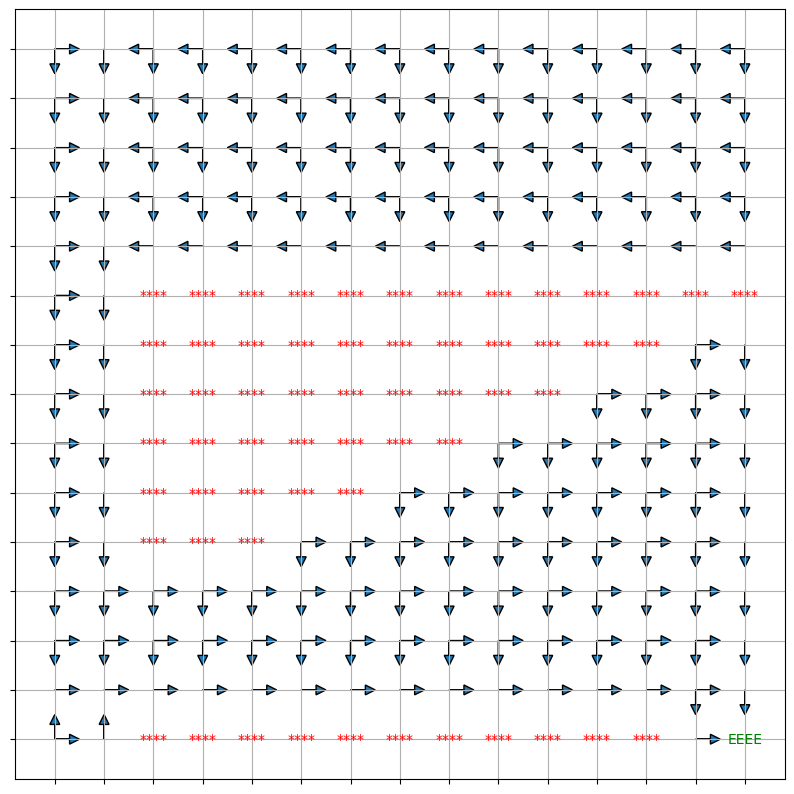

In [7]:
env = CliffEnv2()
agent = PolicyIter(env,debug = False)
agent.ite_policy()
draw_agent(agent)

In [8]:
class CliffEnv3(CliffWalkEnv):
    def __init__(self, *, r_normal=-1, r_cliff=-100):
        super().__init__(nrow=15, ncol=15, r_normal=r_normal, r_cliff=r_cliff)

    def isend(self, row, col):
        return row == 14 and col == 14

    def iscliff(self, row, col):
        # Define the cliff cells for each row
        if row == 4 and 2 <= col <= 4:
            return True
        elif row == 5 and 5 <= col <= 7:
            return True
        elif row == 6 and 8 <= col <= 10:
            return True
        elif row == 7 and 11 <= col <= 13:
            return True
        elif row == 8 and 8 <= col <= 10:
            return True
        elif row == 9 and 5 <= col <= 7:
            return True
        elif row == 10 and 2 <= col <= 4:
            return True
        elif row == 14 and 2 <= col <= 13:
            return True
        return False

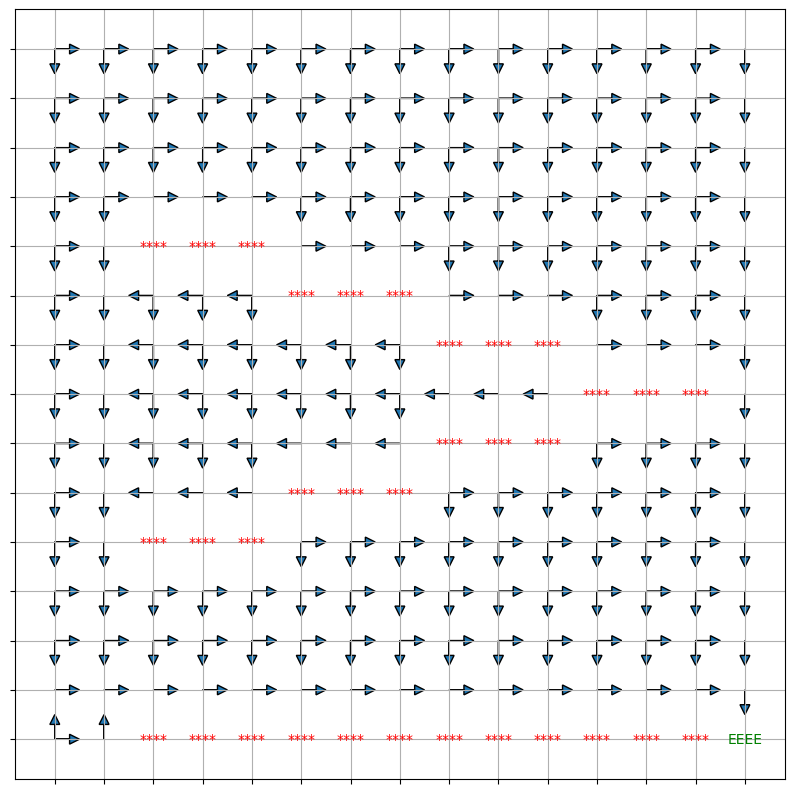

In [9]:
env = CliffEnv3()
agent = PolicyIter(env,debug = False)
agent.ite_policy()
draw_agent(agent)

In [10]:
class CliffEnv4(CliffWalkEnv):
    def __init__(self, *, r_normal=-1, r_cliff=-100):
        super().__init__(nrow=15, ncol=15, r_normal=r_normal, r_cliff=r_cliff)

    def isend(self, row, col):
        return row == 14 and col == 14

    def iscliff(self, row, col):
        # Define the cliff cells for each row
        if row in [1, 3, 5, 7, 9, 11, 13] and col in [3, 6, 9, 12]:
            return True
        elif row in [2, 4, 6, 8, 10, 12] and col in [2, 5, 8, 11, 14]:
            return True
        elif row == 14 and 2 <= col <= 13:
            return True
        return False


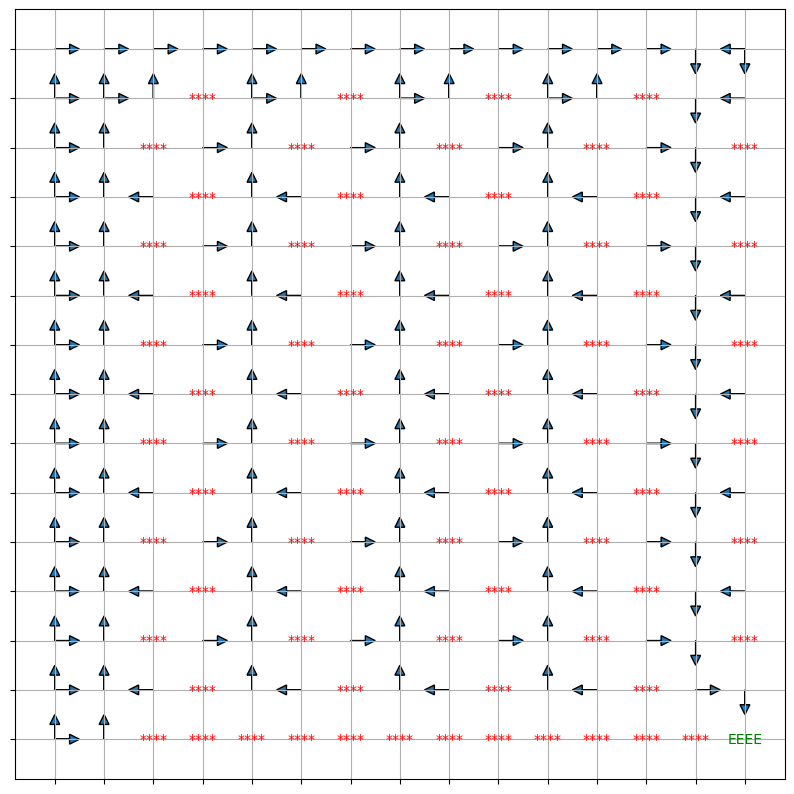

In [11]:
env = CliffEnv4()
agent = PolicyIter(env,debug = False)
agent.ite_policy()
draw_agent(agent)

### B价值迭代算法
使用$\sum_{a \in A} \pi(a \mid s)$可以简单粗暴地理解为是一种包含所有a的平均状态$sum(l\_qsa)$，而贝尔曼最优方程，每次计算的则是直接找出最优$argmax_{a}(l\_qsa)$
$$
V^{k+1}(s) =max_{a \in \mathcal{A}}\left \{r(s, a)+\gamma \sum_{s^{\prime} \in S} p\left(s^{\prime} \mid s, a\right) V^{k}\left(s^{\prime}\right)\right \}
$$
价值迭代的结束，使用不动点，当$V^{k+1}== V^{k}$，对应着最优状态价值函数$V^*$，以及策略：
$$
\pi(s)=\arg \max _{a \in \mathcal{A}}\left\{r(s, a)+\gamma \sum_{s^{\prime} \in \mathcal{S}} P\left(s^{\prime} \mid s, a\right) V^k\left(s^{\prime}\right)\right\}
$$
> 注意：价值迭代中不存在显式的策略，我们只维护一个状态价值函数

#### 算法流程如下：
- 随机初始化策略 $ \pi(s) $ 和价值函数 $ V(s) $
- **while $ \Delta>\theta $ do :** (策略评估循环)
- $ \Delta \leftarrow 0 $
- ----对于每一个状态 $ s \in \mathcal{S} $ :
- --------$ v \leftarrow V(S) $
- --------$ V(s) \leftarrow max_a  r(s, a)+\gamma \sum_{s^{\prime}} P\left(s^{\prime} \mid s, \pi(s)\right) V\left(s^{\prime}\right)$
- --------$ \Delta \leftarrow \max (\Delta,|v-V(s)|) $
- **end while**
- 直接返回确定性策略$\pi(s)=\arg \max _{a \in \mathcal{A}}\left\{r(s, a)+\gamma \sum_{s^{\prime} \in \mathcal{S}} P\left(s^{\prime} \mid s, a\right) V^k\left(s^{\prime}\right)\right\}$

### B价值迭代算法 -- 类设计
class ValueIter
数据结构：
- env 环境
- Pi[s] 策略,使用列表[]动作概率分布(但是最后才会得到)
- V[s] 价值函数
- theta 策略评估收敛阈值
- gamma 折扣因子

方法：
- ~~eva_policy 策略评估~~
- ~~imp_policy 策略提升~~
- ite_value 策略迭代
- get_policy 导出策略

In [16]:
class ValueIter:
    def __init__(self, env, *, theta=0.001, gamma=0.9, debug=False):
        self.env = env
        self.theta = theta
        self.gamma = gamma
        self.Pi = [[1 / len(self.env.A)] * len(self.env.A)
                   for _ in range(self.env.nrow * self.env.ncol)]
        self.V = [0] * self.env.nrow * self.env.ncol
        self.debug = debug
    
    def ite_value(self):
        cnt = 0
        while True:
            max_diff = 0
            new_V = [0] * self.env.nrow * self.env.ncol
            for s in range(self.env.nrow*self.env.ncol):
                l_qsa = []
                for a in range(len(self.env.A)):
                    qsa = 0
                    for res in self.env.P[s][a]:
                        p, next_s, r, flag = res
                        qsa += p*(r+self.gamma*self.V[next_s]*(1-flag)) 
                    l_qsa.append(qsa) #注意：这里被合并了
                new_V[s] = max(l_qsa)
                max_diff = max(max_diff,abs(new_V[s]-self.V[s]))
            self.V=new_V
            if max_diff < self.theta: break
            cnt +=1
        if self.debug: print("价值迭代一共进行%d轮" % cnt)
        self.get_policy()
    
    def get_policy(self):  # 根据价值函数导出一个贪婪策略
        for s in range(self.env.nrow * self.env.ncol):
            l_qsa = []
            for a in range(4):
                qsa = 0
                for res in self.env.P[s][a]:
                    p, next_s, r, flag = res
                    qsa += p * (r + self.gamma * self.V[next_s] * (1 - flag))
                l_qsa.append(qsa)
            maxq = max(l_qsa)
            cntq = l_qsa.count(maxq)
            self.Pi[s] = [1 / cntq if q == maxq else 0 for q in l_qsa]
        

价值迭代一共进行29轮


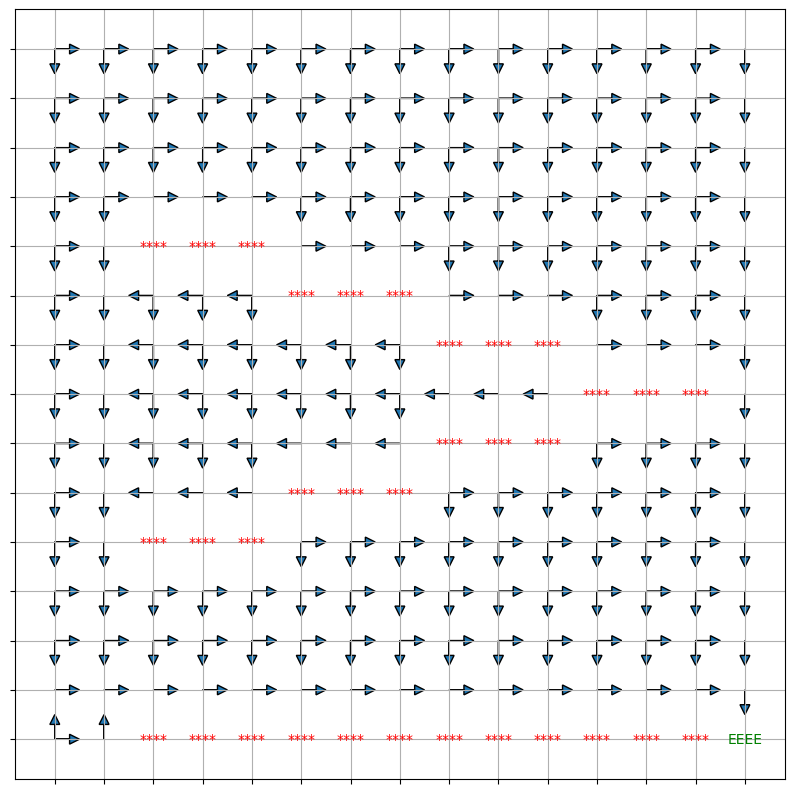

In [17]:
env = CliffEnv3()
agent = ValueIter(env,debug = True)
agent.ite_value()
draw_agent(agent)

### 总结：
本章讲解了强化学习中两个经典的动态规划算法：「策略迭代算法」和「价值迭代算法」，它们都能用于求解最优价值和最优策略。
动态规划的主要思想是利用贝尔曼方程对所有状态进行更新。

> 注意:贝尔曼方程进行状态更新，奖励函数和状态转移函数必须提前知道。

如果智能体无法事先得知奖励函数和状态转移函数，就只能通过和环境进行交互来采样（状态-动作-奖励-下一状态）这样的数据，我们将在之后的章节中讲解如何求解这种情况下的最优策略。

### 扩展阅读：收敛性证明
[收敛性证明](https://hrl.boyuai.com/chapter/1/%E5%8A%A8%E6%80%81%E8%A7%84%E5%88%92%E7%AE%97%E6%B3%95/)